In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [15]:
names = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "vision",
    "temp",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "epoch",
    "loss",
    "acc",
    "score",
    # "best",
    "wait",
    "patience",
    "test",
]

categories = [
    "seed",
    "depth",
    "window",
    "method",
    "budget",
    "vision",
    "temp",
    "opt",
    "lr",
    "num_nodes",
    "num_layers",
    "patience",
]


def get_df(v):
    df = pd.read_csv(
        f"/storage1/fs1/chien-ju.ho/Active/tree/output{v}.txt", names=names
    )
    df['dup'] = (df.epoch == 0).astype(int)
    df['dup'] = df.groupby(categories)['dup'].cumsum()
    df = df.groupby(categories + ['dup']).filter(lambda x: x['wait'].max() == x['patience'].iloc[0])
    df = df[df.wait == 0]
    df = df.drop_duplicates(categories + ['dup'], keep='last')
    df = df.groupby(categories).mean().reset_index()
    df['skill'] = df.apply(lambda x: f"({x.vision}, {x.temp})", axis=1)
    return df

In [16]:
%%time
df = get_df(18)
df

CPU times: user 2min 15s, sys: 10.2 s, total: 2min 25s
Wall time: 2min 41s


,seed,depth,window,method,budget,vision,temp,opt,lr,num_nodes,num_layers,patience,epoch,loss,acc,score,wait,test,dup,skill
0,0,2,0,normal-0-0,1,1,0.00,adam,1.0,16,1,20,112.0,0.635044,0.630500,0.613997,0.0,0.581451,1.0,"(1, 0.0)"
1,0,2,0,normal-0-0,1,2,0.00,adam,1.0,16,1,20,2.0,0.803121,0.444500,-0.124295,0.0,-0.126232,1.0,"(2, 0.0)"
2,0,2,0,normal-0-0,1,2,0.01,adam,1.0,16,1,20,45.0,0.775687,0.544250,0.244185,0.0,0.264131,1.0,"(2, 0.01)"
3,0,2,0,normal-0-0,1,2,0.10,adam,1.0,16,1,20,0.0,0.835660,0.450250,-0.068380,0.0,-0.114524,1.0,"(2, 0.1)"
4,0,2,0,normal-0-0,1,2,1.00,adam,1.0,16,1,20,34.0,0.758305,0.533000,0.249632,0.0,0.171739,1.0,"(2, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305528,716,4,0,normal-0-0,1,4,0.01,adam,1.0,16,1,20,0.0,0.820713,0.501250,0.042386,0.0,0.070690,1.0,"(4, 0.01)"
305529,716,4,0,normal-0-0,1,4,0.10,adam,1.0,16,1,20,0.0,0.809362,0.496750,0.074432,0.0,0.101013,1.0,"(4, 0.1)"
305530,716,4,0,normal-0-0,1,4,1.00,adam,1.0,16,1,20,80.0,0.932204,0.498625,-0.022512,0.0,0.083989,1.0,"(4, 1.0)"
305531,717,4,0,normal-0-0,1,1,0.00,adam,1.0,16,1,20,26.0,0.792574,0.484375,-0.062383,0.0,0.109665,1.0,"(1, 0.0)"


(8, 8)


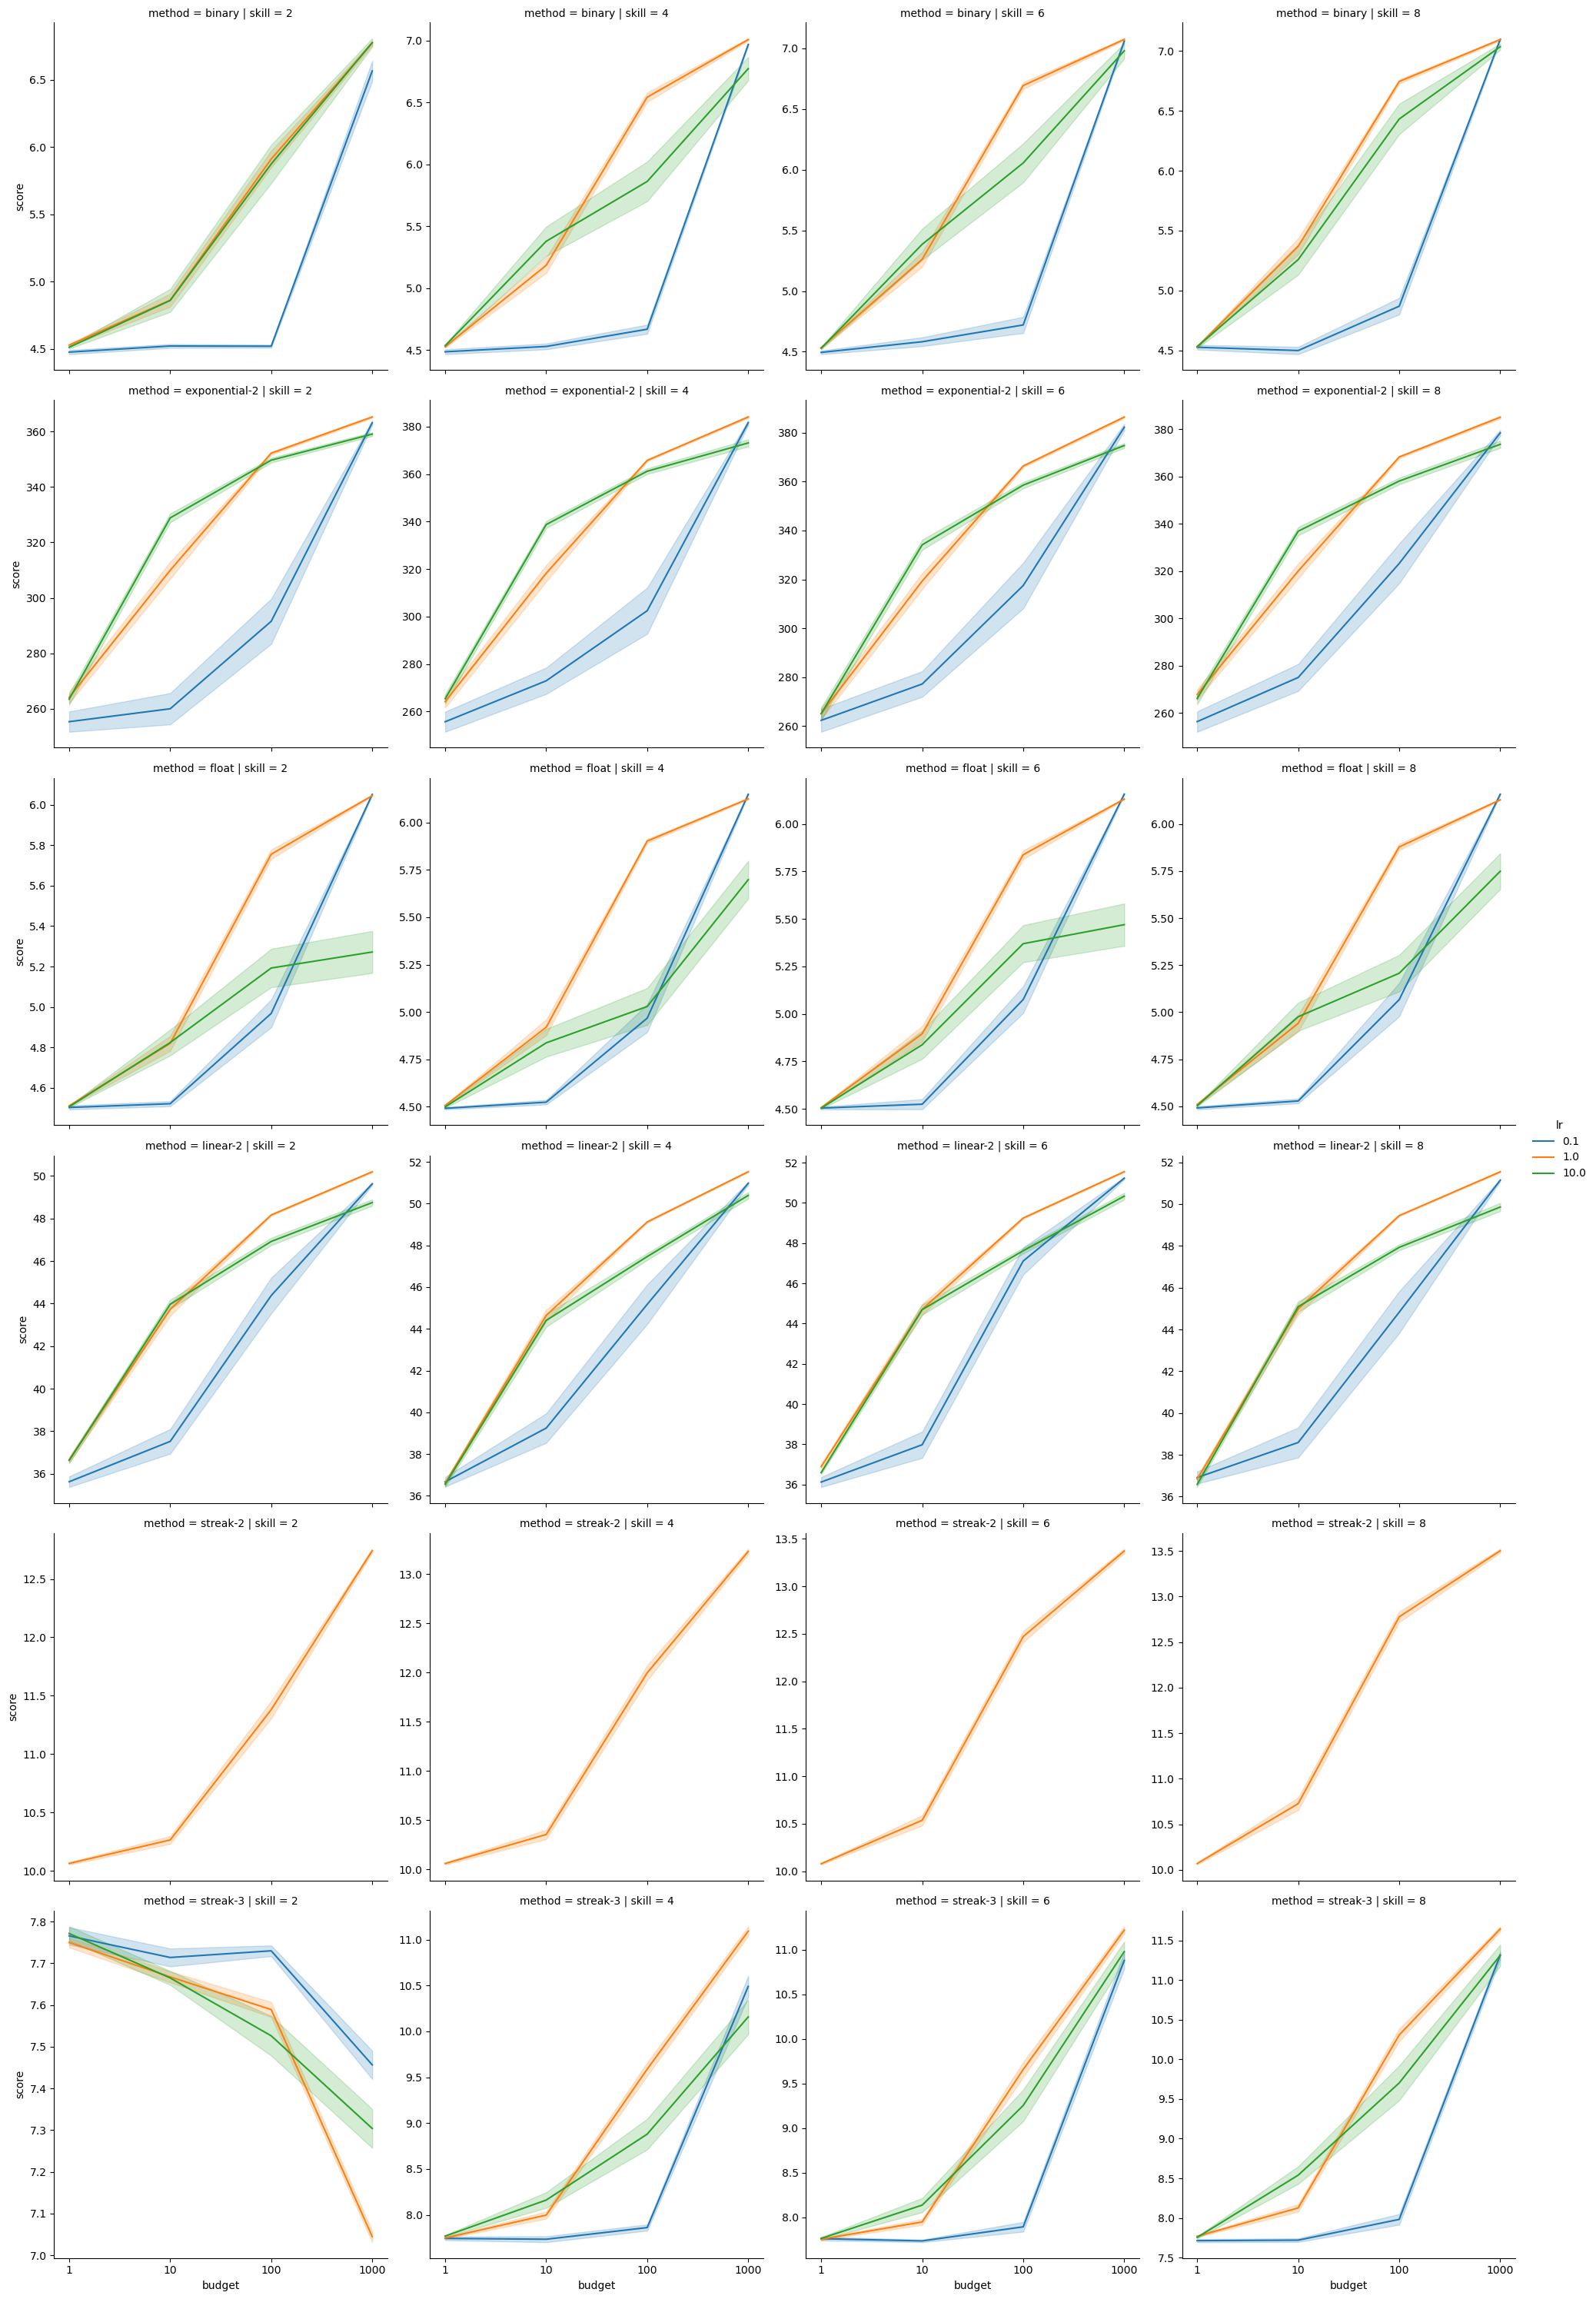

(12, 8)


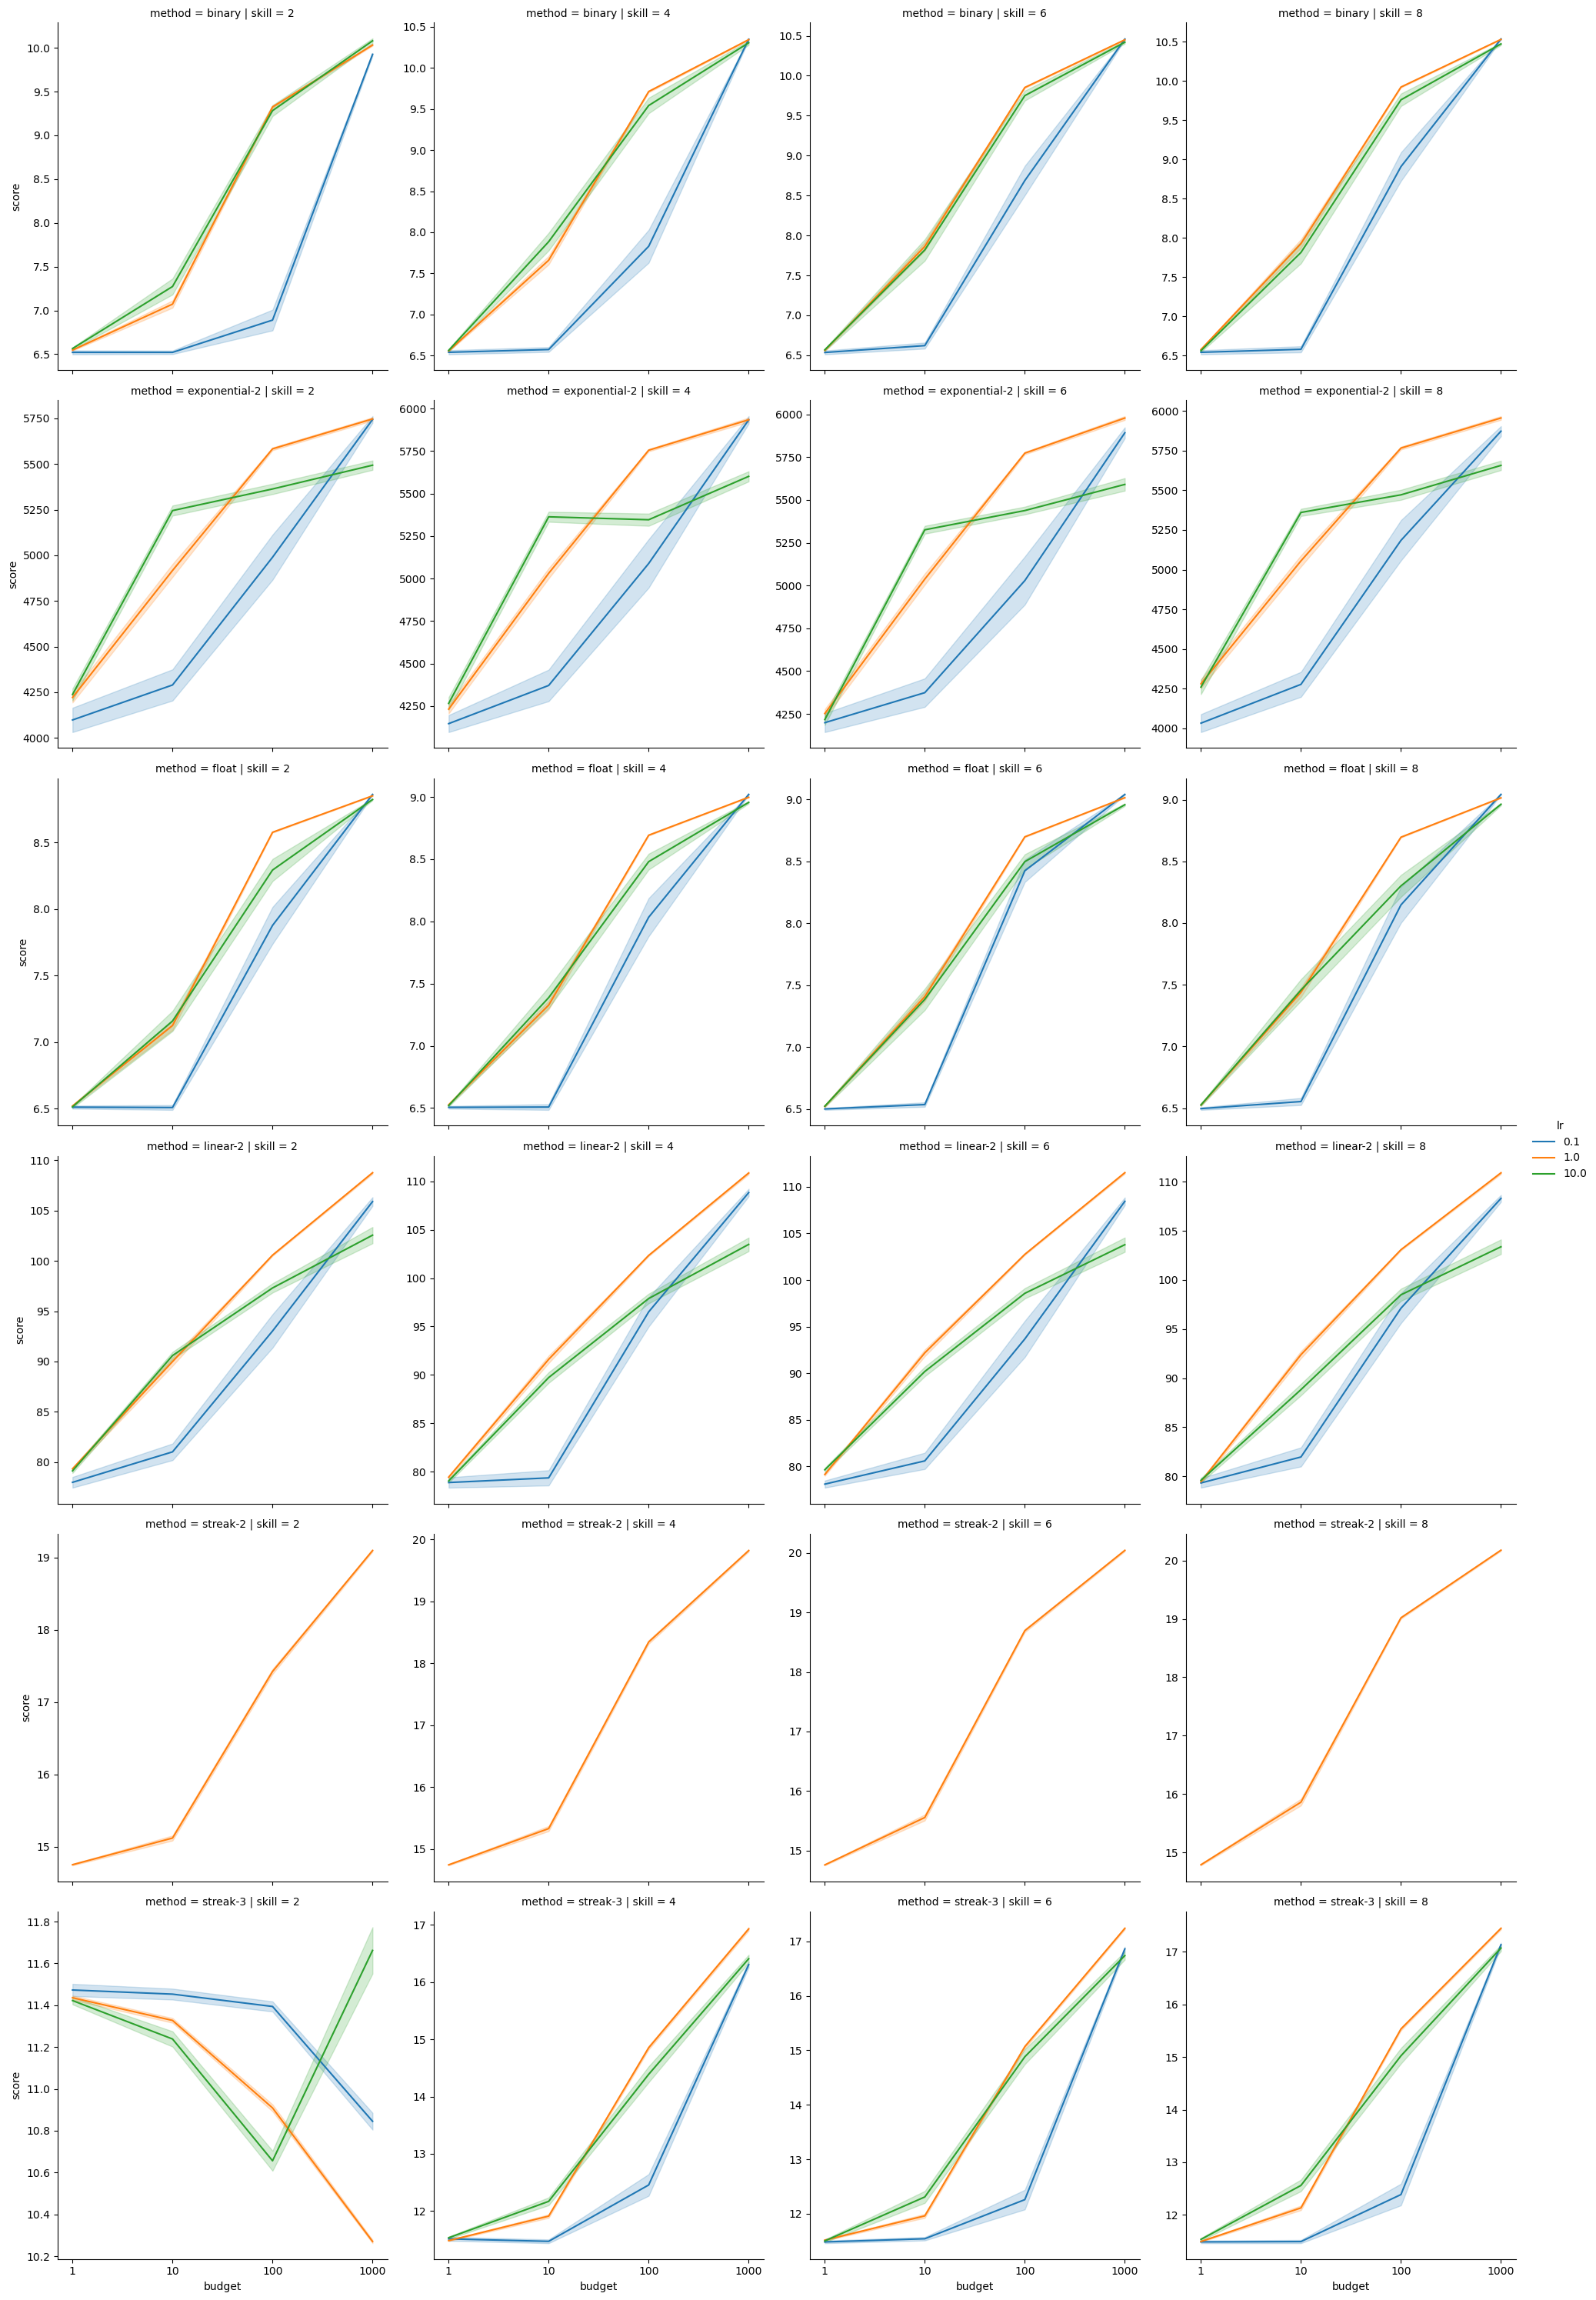

(12, 12)


KeyboardInterrupt: 

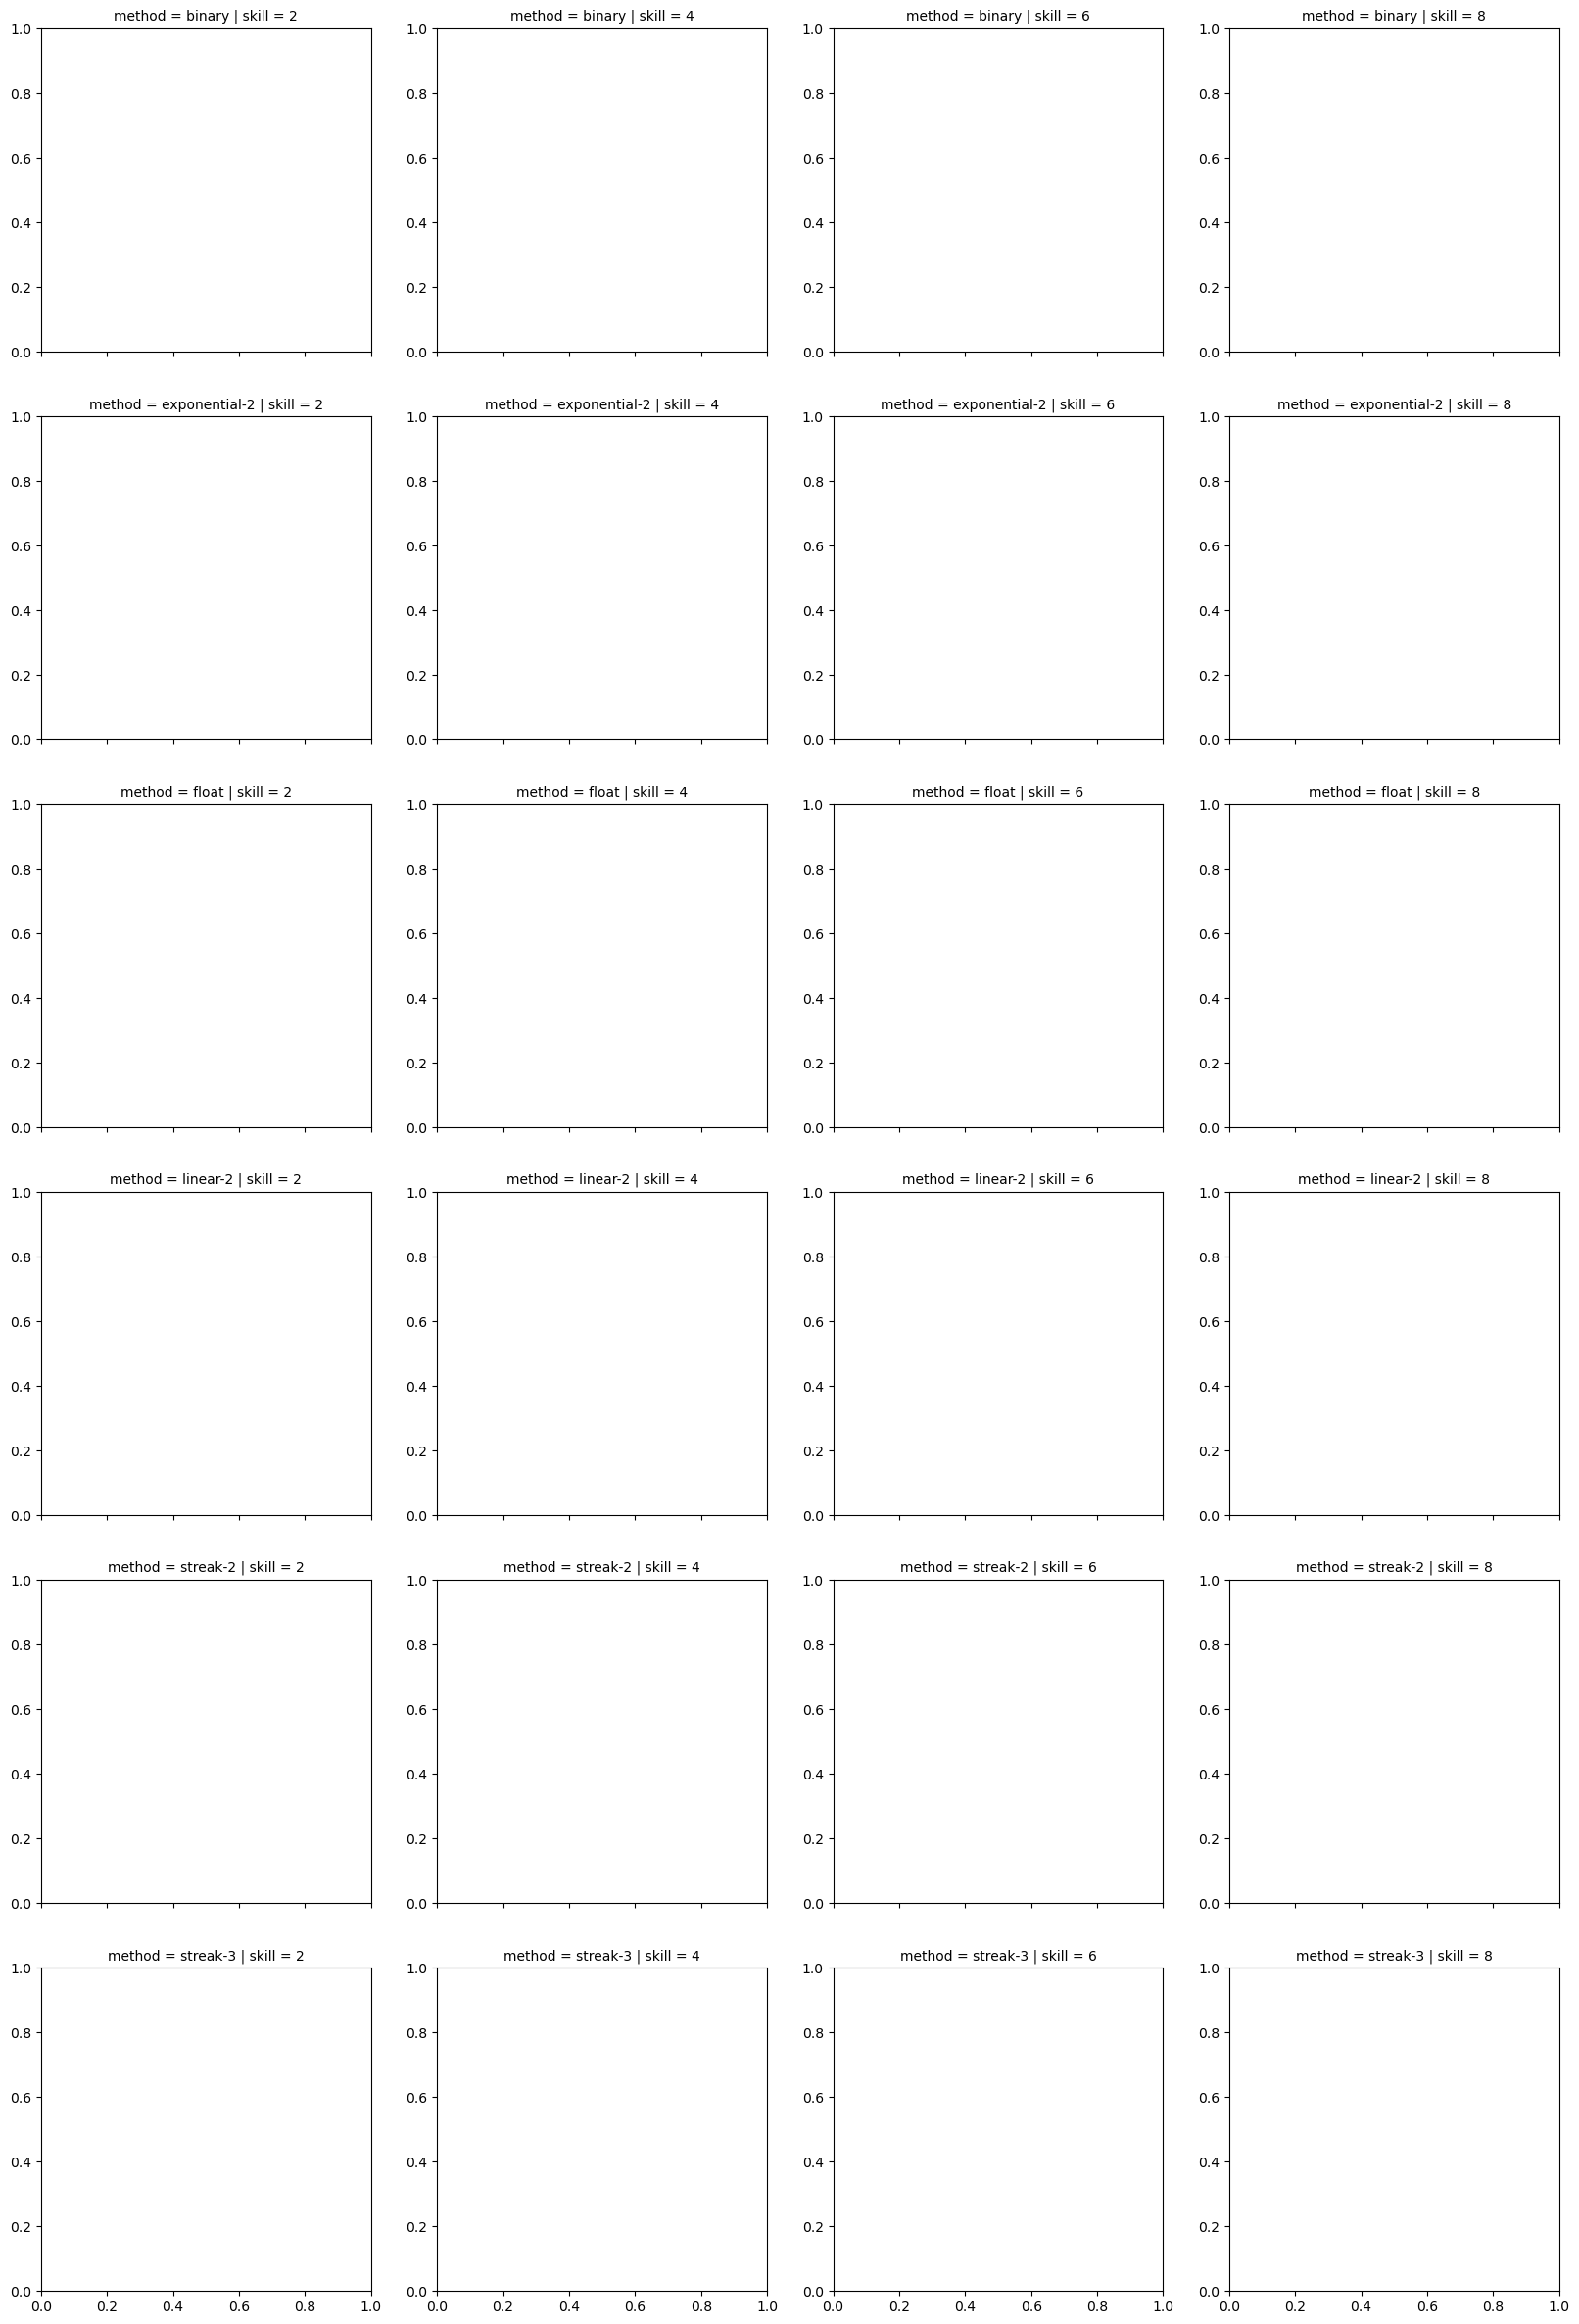

In [196]:
for d, df in df13[df13.depth.isin([8,12,16,20])].groupby(['depth',"window"]):
    print(d)
    df_ = df.astype({"budget": "str", "lr": "str"})
    g = sns.relplot(
        data=df_,
        x="budget",
        y="score",
        hue="lr",
        row="method",
        col="skill",
        kind="line",
        errorbar="se",
        facet_kws={'sharey': False}
    )
    display(g.figure)
    plt.close(g.figure)
    print("="*50)

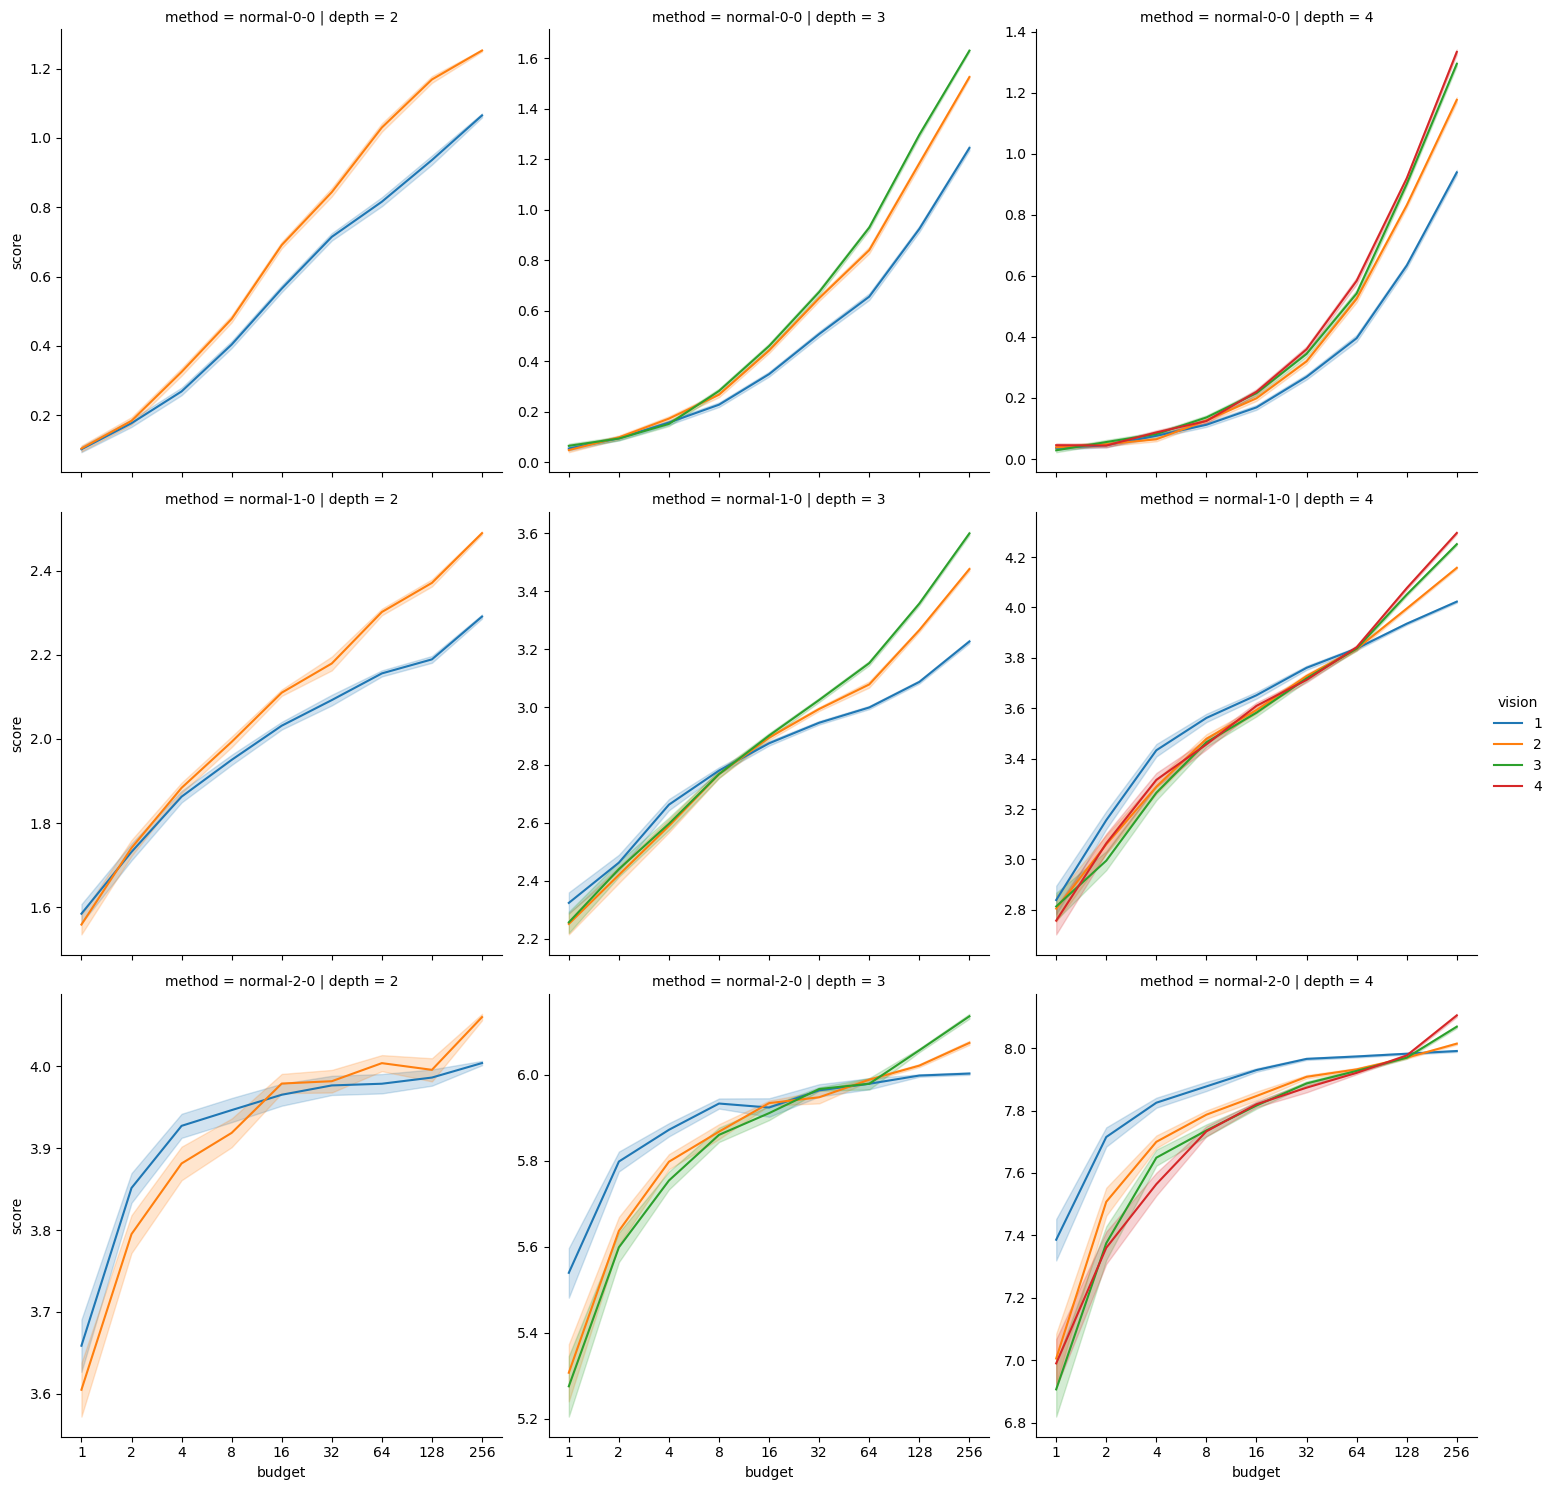

In [18]:
# skill = 'temp'
skill = 'vision'

if skill == 'temp':
    df_ = df[df.temp != 0]
else:
    df_ = df[df.temp == 0]
df_ = df_.astype({"budget": "str", "vision":"str", "temp":"str"})
    
g = sns.relplot(
    data=df_,
    x="budget",
    y="score",
    hue=skill,
    row="method",
    col="depth",
    kind="line",
    errorbar="se",
    facet_kws={'sharey': False},
)
display(g.figure)
plt.close(g.figure)

methods = list(df_.method.unique())

def color_alternate_columns(row):
    def get_style(idx, value):
        style = ''
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"
            
        max_val = max(value_ for idx_, value_ in row.items() if idx_[0] == idx[0])
        if value == max_val:
            style += "font-weight: bold;"
        return style
    
    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors

pivoted = df_.pivot_table(index=["method","budget"], columns=["depth", skill], values="test")
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=3))

def color_alternate_columns(row):
    def get_style(idx, value):
        style = ''
        if (idx[0] + methods.index(row.name[0])) % 2 == 0:
            style += "background-color: #E6F3FF;"
        else:
            style += "background-color: #E6FFE6;"
        return style    
    colors = [get_style(idx, value) for idx, value in row.items()]
    return colors


pivoted = df_.pivot_table(index=["method","budget"], columns=["depth", skill], values="seed", aggfunc=len)
display(pivoted.style.apply(color_alternate_columns, axis=1).format(precision=0))